In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Applying linear regression on data scraped from Funda

Use the [funda-scraper](https://pypi.org/project/funda-scraper/) to scrape data from funda. In this notebook, we read the Funda data from a pickle file

In [2]:
houses_df = pd.read_pickle('houses_df.pkl')
houses_df.drop(columns=['house_id', 'address', 'descrip'], inplace=True)

### Inspect the data

In [3]:
houses_df.head()

,city,house_type,building_type,price,price_m2,room,bedroom,bathroom,living_area,energy_label,zip,year_built,house_age,date_list,ym_list,year_list
0,amsterdam,appartement,Bestaande bouw,400000,8000.0,2,1,1,50,D,1056,1930,93,2023-08-29,2023-08-01,2023
1,amsterdam,appartement,Bestaande bouw,450000,6923.1,4,3,1,65,C,1091,1960,63,2023-08-29,2023-08-01,2023
2,amsterdam,appartement,Bestaande bouw,300000,4545.5,3,2,1,66,B,1106,1983,40,2023-08-28,2023-08-01,2023
3,amsterdam,appartement,Bestaande bouw,625000,6377.6,3,2,1,98,A,1061,2013,10,2023-08-28,2023-08-01,2023
4,amsterdam,appartement,Bestaande bouw,485000,4754.9,4,3,1,102,D,1024,1967,56,2023-08-29,2023-08-01,2023


### Apply simple linear regression to predict price from living_area

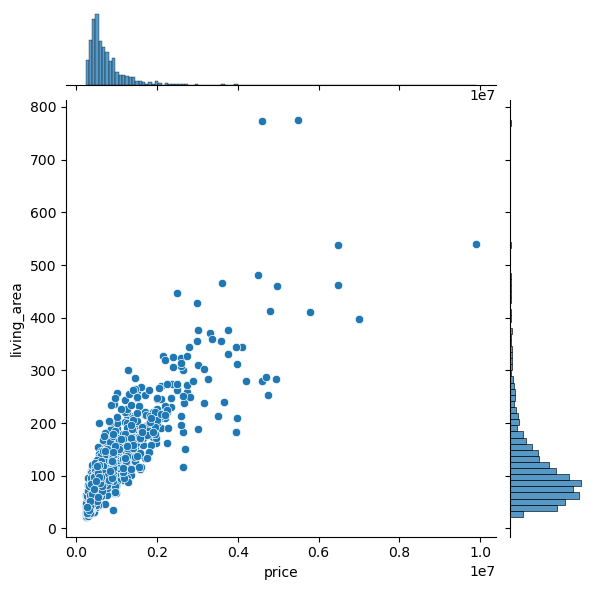

In [4]:
sns.jointplot(x='price', y='living_area', data=houses_df, kind='scatter')

#### Deciding that we don't want to buy a house more expensive than 1,000,0000

Early findings:
- Price most dense around €500,000
- Living area most dense around 80 $m^2$
- Relationship seems linear, however the variance increases for prices/living area

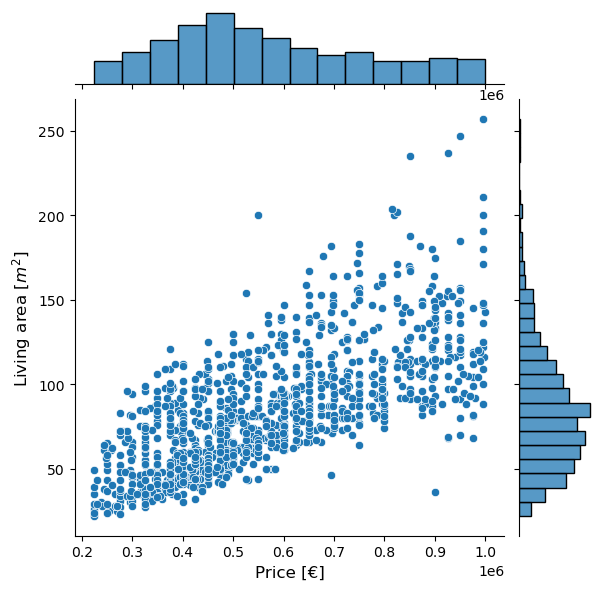

In [5]:
mil_df = houses_df[houses_df.price<1000000]
jplot = sns.jointplot(x='price', y='living_area', data=mil_df, kind='scatter')
jplot.set_axis_labels('Price [€]', 'Living area [$m^2$]', fontsize=12)

#### Split the data in a train and test set

In [6]:
X = mil_df['living_area']
y = mil_df['price']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
len(x_train)

975

### Draft cells below

Text(0.5, 1.0, 'House Price vs Living Area, colored by Listing Date')

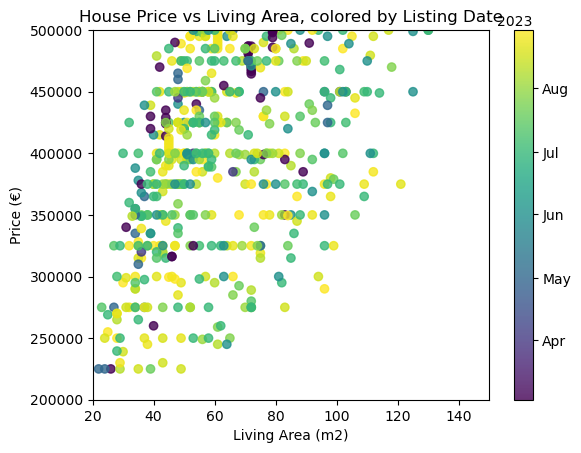

In [22]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
# sns.scatterplot(data=houses_df, x='living_area', y='price', hue = 'date_list',  palette='RdBu', ax = ax)

plt.scatter(houses_df['living_area'], houses_df['price'], c=mdates.date2num(houses_df['date_list']), cmap='viridis', alpha=0.8)
cb = plt.colorbar()
loc = mdates.AutoDateLocator()
cb.ax.yaxis.set_major_locator(loc)
cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
ax.set_ylim(200000, 500000)
ax.set_xlim(20, 150)
ax.set_ylabel('Price (€)')
ax.set_xlabel('Living Area (m2)')
ax.set_title('House Price vs Living Area, colored by Listing Date')


<AxesSubplot: >

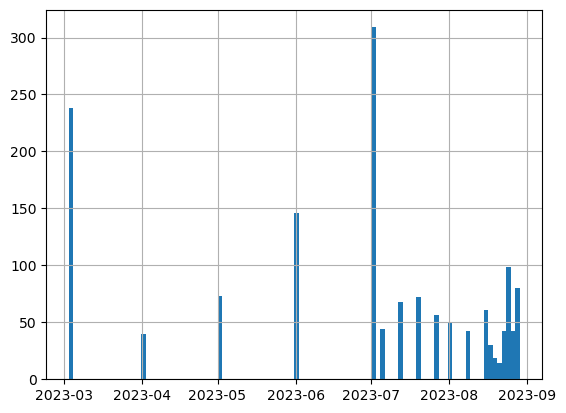

In [7]:
houses_df.date_list.hist(bins = 100)